# Fine tuning 

In [1]:
from transformers import (Trainer, TrainingArguments, EarlyStoppingCallback,
                          DataCollatorForLanguageModeling, AutoModelForCausalLM, AutoTokenizer)
from datasets import load_dataset
from typing import Optional, Tuple
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import accelerate
import keras

/home/kevin/MEGA/text_mining/text-mining/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-04 15:09:58.969389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 15:09:58.988381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 15:09:58.993181: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 15:09:59.008538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This 

In [2]:
dataset = load_dataset('mrm8488/CHISTES_spanish_jokes', split='train')
dataset

Dataset({
    features: ['id', 'text', 'keywords', 'funny', 'category'],
    num_rows: 2419
})

In [3]:
dataset.set_format('pandas')
df = dataset.to_pandas()
df.head(10)

,id,text,keywords,funny,category
0,0,"- ¡Rápido, necesitamos sangre!\n- Yo soy 0 pos...",sangre,1,otros
1,1,- ¿Cuál es el mejor portero del mundial? \n- E...,"futbol,porteros",1,otros
2,2,El otro día unas chicas llamarón a mi puerta y...,"dinero,agua",1,otros
3,3,"- Andresito, ¿qué planeta va después de Marte?...",planetas,1,profesiones
4,4,- ¿Por qué Bob Esponja no va al gimnasio? \n- ...,"esponja,gimnasios",1,otros
5,5,Van dos ciegos y le dice uno al otro: \n- Ojal...,ciegos,1,otros
6,6,Noticia de última hora!! \n\nMuere una suegra ...,"canarias,coches,noticias",2,familia
7,7,"– Mamá, mamá, en el colegio dicen que estoy lo...","locos,sillas",1,familia
8,8,"– Mamá, mamá, ¿me haces un bocata de jamón?\n–...","madres,jamón",1,otros
9,9,- Qué pasa si te expulsan de cuatro univerdade...,"universitarios,universidades",1,otros


In [4]:
def jokes_last(df):
    '''
    Agrega <fin> al final de cada chiste si no está presente
    '''
    df['text'] = df['text'].apply(
        lambda x: x.strip() if x.strip().endswith('<fin>') else x.strip() + ' <fin>')
    return df


df = jokes_last(df)
print(df['text'][3])

- Andresito, ¿qué planeta va después de Marte? 
- Miércole, señorita. <fin>


## Preparando el conjunto de datos

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "DeepESP/gpt2-spanish"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model

/home/kevin/MEGA/text_mining/text-mining/env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
def preprocess_function(max_len):
    def _preprocess_function(examples):
        return tokenizer(
            examples['text'],
            max_length=max_len,
            truncation=True,
            padding='longest',
            return_tensors='pt'
        )
    return _preprocess_function

In [7]:
dataset.reset_format()
tokenized_dataset = dataset.map(preprocess_function(max_len=256), batched=True)
tokenized_dataset = tokenized_dataset.remove_columns([col for col in tokenized_dataset.column_names if col != 'input_ids'])
tokenized_dataset = tokenized_dataset.train_test_split(train_size=0.70)
tokenized_dataset.set_format('torch')
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 1693
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 726
    })
})

In [8]:
# Muestra la primera entrada del dataset tokenizado
print(tokenized_dataset['train'][0])

# lo decodeamos
tokenizer.decode(tokenized_dataset['train'][0]['input_ids'])

{'input_ids': tensor([ 2243, 16195,    21,   268,  2464,   304,  1076, 14752,    21,   314,
         3854,   281,   304, 36008,   293,   324,   426,  2324,    35,   208,
           22,   576,  2776,  4168,   297,  1465,   297, 37595,   296,    40,
          208,    22,  7520,  4199,   307,  2129,  9113,    21, 15558,  3837,
          337, 16064,   313,    23, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 

'Un camarero, de esos un poco pelota, se acerca a un comensal y le dice:\n- ¿Cómo encontró el señor el filete?\n- Pues realmente con mucha dificultad, escondido debajo del puré.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

In [9]:
epochs = 10
batch_size = 8
logging_steps = len(tokenized_dataset['train']) // batch_size

# Definimos los parámetros globales de entrenamiento
training_args = TrainingArguments(
    output_dir='./hf-gpt',
    overwrite_output_dir=True,
    num_train_epochs=epochs,
    learning_rate=2e-5,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',  # Cambiado de evaluation_strategy a eval_strategy
    save_strategy='epoch',  # Guardamos al final de cada época
    load_best_model_at_end=True,  # Cargamos el mejor modelo al final
    disable_tqdm=False,
    logging_steps=logging_steps,
    save_total_limit=2,
    # Utilizamos eval_loss como métrica de referencia
    metric_for_best_model="eval_loss",
    greater_is_better=False  # Indica que buscamos minimizar eval_loss
)

# Crear el callback para early stopping, asegurándote de que no se repita
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# Definir el entrenador, asegurando que no se añadan múltiples callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False),
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    callbacks=[early_stopping_callback]  # Solo se añade una vez
)

Descripcion de los argumentos:
- `num_train_epochs`: Número de iteraciones de entrenamiento.
- `learning_rate`: Tasa de aprendizaje para el optimizador, Un valor más alto puede acelerar el entrenamiento, pero un valor demasiado alto puede hacer que el modelo no converja.
- `per_device_train_batch_size`: Tamaño del lote por dispositivo de entrenamiento.
- `per_device_eval_batch_size`: Tamaño del lote por dispositivo de evaluación.
- `weight_decay`: Tasa de decaimiento de los pesos, que ayuda a evitar el sobreajuste al añadir una penalización a los pesos grandes.
- `eval_strategy`: significa que evalua al final de cada epoch.
- `save_strategy`: significa que guarda el modelo al final de cada epoch.
- `load_best_model_at_end`: significa que carga el mejor modelo al final del entrenamiento.
- `logging_steps`: Cada cuántos pasos se imprime el log.

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.481500,3.176255
2,2.161100,3.216372
3,2.114400,3.227968
4,1.919600,3.261066


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=848, training_loss=2.168072089834033, metrics={'train_runtime': 6211.2886, 'train_samples_per_second': 2.726, 'train_steps_per_second': 0.341, 'total_flos': 3144580551671808.0, 'train_loss': 2.168072089834033, 'epoch': 4.0})

In [33]:
# Guardamos el modelo (solo correr si se vuelve a entrenar el modelo)
#trainer.save_model('trained-gpt2-with-stop')
#tokenizer.save_pretrained('trained-gpt2-with-stop')

('trained-gpt2-with-stop/tokenizer_config.json',
 'trained-gpt2-with-stop/special_tokens_map.json',
 'trained-gpt2-with-stop/vocab.json',
 'trained-gpt2-with-stop/merges.txt',
 'trained-gpt2-with-stop/added_tokens.json',
 'trained-gpt2-with-stop/tokenizer.json')

In [10]:
# Correr para cargar el modelo pre-entrenado
model = AutoModelForCausalLM.from_pretrained('trained-gpt2-with-stop')
tokenizer = AutoTokenizer.from_pretrained('trained-gpt2-with-stop')

In [12]:
# Datos
epochs = [1, 2, 3, 4]
training_loss = [2.481500, 2.161100, 2.114400, 1.919600]
validation_loss = [3.176255, 3.216372, 3.227968, 3.261066]

epochs2 = list(range(1, 16))
training_loss2 = [3.347200, 2.896200, 2.597600, 2.349400, 2.134900, 1.937500,
                     1.777700, 1.640100, 1.513900, 1.421800, 1.334000, 1.273000,
                     1.222700, 1.180900, 1.168000]
validation_loss2 = [3.188109, 3.147020, 3.147712, 3.170731, 3.194566, 3.222896,
                       3.257123, 3.285432, 3.307516, 3.334086, 3.355662, 3.369654,
                       3.382810, 3.388117, 3.391587]

def plot(epochs, training_loss, validation_loss, title:str):
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, validation_loss,
             label='Validation Loss', marker='o', color='red')

    # Etiquetas y Título
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Training vs Validation Loss')

    # Leyenda
    plt.legend()

    # Mostrar el gráfico
    plt.grid(True)
    plt.show()

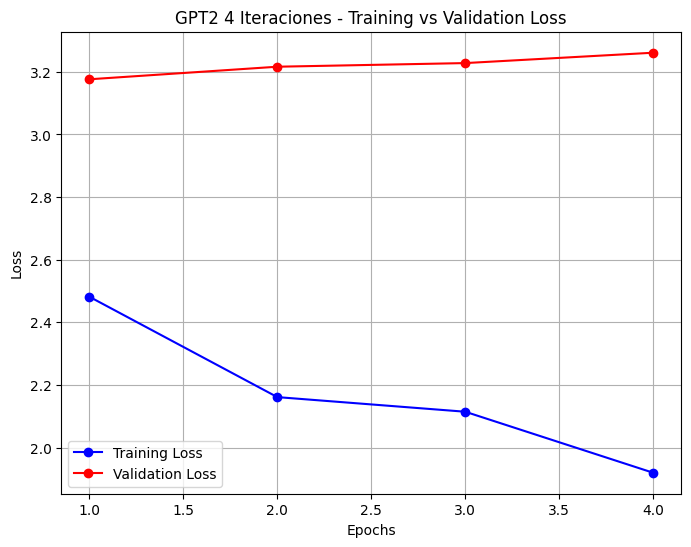

In [98]:
plot(epochs, training_loss, validation_loss, 'GPT2 4 Iteraciones')

La curva azul disminuye en cada iteracion lo que indica que el conjnto de datos de entrenamiento esta aprendiendo del conjunto de datos de entrenamienot y ajustando mejor sus parametros. La curva roja (validation loss) se mantiane bastante constante y ligeramente creciante lo que indica que el modelo se puede estar sobre ajustando. 
Cabe resaltar que este modelo inicialmente fue entrenado con 10 epochs y usamos early stopping para que se detenga cuanod la validation loss no disminuya en 3 epochs.

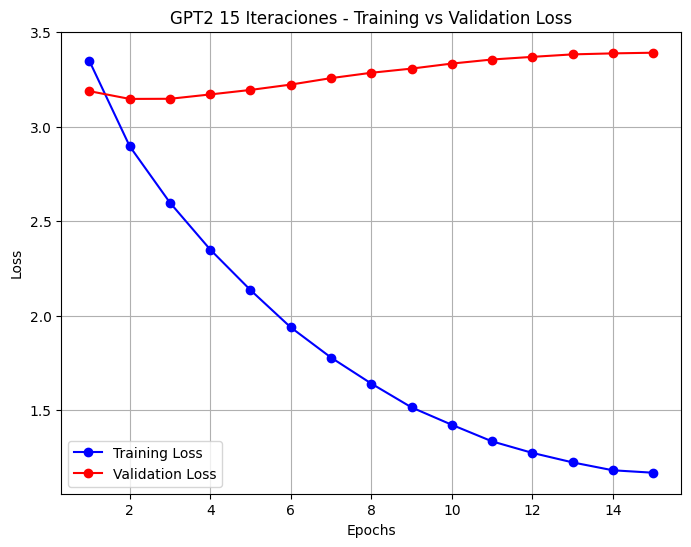

In [13]:
plot(epochs2, training_loss2, validation_loss2, 'GPT2 15 Iteraciones')

La curva azul disminuye en cada iteracion drasticamente, mostrando que el modelo continua aprendiendo, señal que esta mejorando su rendimiento. Por otra parte la curva roja comienza estable pero luego muestra una tendencia a aumentar en las iteraciones esto sugiere que el modelo esta comenzando a sobreajustar el conjunto de datos de entrenamiento, ya que la generalizacion a los datos de validacion no mejora.

Dado que ya aplicamos Early Stopping, podriamos aplicar regularización, como técnicas de dropout o L2 regularization, podría ayudar a mejorar la generalización del modelo, reduciendo el sobreajuste (ver).

In [16]:
text = 'Habia una vez un hombre que'
best = 10

with torch.no_grad():
    tokens = tokenizer(text, return_tensors='pt')['input_ids'].to(device)
    print("Dimensiones de la entrada:", tokens.shape)
    output = model(input_ids=tokens)
    print("Dimensiones de la salida:", output.logits.shape)
    output = output.logits[0, -1, :]
    print("Dimensiones del último token de la secuencia:", output.shape)
    probs = torch.softmax(output, dim=-1)
    print("Dimensiones de la probabilidad de los tokens:", probs.shape)
    sorted_probs = torch.argsort(probs, dim=-1, descending=True)
    print({tokenizer.decode(token): f"{prob.cpu().numpy() * 100:.2f}%" for token,
          prob in zip(sorted_probs[:best], probs[sorted_probs[:best]])})

Dimensiones de la entrada: torch.Size([1, 7])
Dimensiones de la salida: torch.Size([1, 7, 50257])
Dimensiones del último token de la secuencia: torch.Size([50257])
Dimensiones de la probabilidad de los tokens: torch.Size([50257])
{' estaba': '14.03%', ' se': '12.76%', ' tenía': '10.91%', ' había': '5.96%', ' era': '5.19%', ' iba': '4.74%', ' quería': '4.43%', ' no': '4.28%', ' vivía': '3.38%', ' fue': '1.86%'}


In [28]:
import torch


def generate_humor_comment(prompt: str, max_length: int = 150, num_return_sequences: int = 1) -> str:
    """
    Genera un comentario humorístico basado en un prompt usando el modelo GPT-2 entrenado.
    
    Args:
    - prompt (str): El texto o conjunto de palabras inicial para generar el comentario.
    - max_length (int): La longitud máxima del comentario generado.
    - num_return_sequences (int): El número de secuencias generadas. 
    
    Returns:
    - str: El comentario humorístico generado.
    """
    model.eval()  # Poner el modelo en modo evaluación

    # Tokenizamos el prompt con padding y truncation en la fase de tokenización
    inputs = tokenizer(prompt, return_tensors="pt", padding=True,
                       truncation=True, max_length=max_length).to(device)

    # Generamos texto con el modelo entrenado
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,  # Evitar repetición de n-gramas
            top_k=50,  # Reducir el espacio de búsqueda
            top_p=0.95,  # Aplicar nucleus sampling
            temperature=0.7,  # Ajustar la creatividad de la generación
            do_sample=True  # Permitir sampling en vez de greedy decoding
        )

    # Decodificar el texto generado de nuevo a formato legible
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text


# Ejemplo de uso
keywords = "profesor jaimito"
comentario_generado = generate_humor_comment(keywords, max_length=150)
print(comentario_generado)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


profesor jaimito en el colegio:
- Muy bien hijo, muy bien.
-¿Y qué es un profesor?
-¡Un profesor!
El profesor: - ¿Y a que se dedica? ¿Qué es una profesora?: 
Jaimita:- Es un alumno...........¡y tiene que trabajar con los niños! :..¡es un maestro!? ;.....
Y dice el profesor : - ¡No se preocupe hijo que es bueno!.. Y le dice al alumno:!!.. ¡¡¡que es muy bueno!!!.. El alumno le responde:, ¡¡no, no, es que no puede trabajar así!...
¿Y usted qué le hace?,


In [30]:
import torch


def generate_humor_comment(keywords: list, max_length: int = 150, num_return_sequences: int = 1) -> str:
    """
    Genera un comentario humorístico basado en una lista de keywords usando el modelo GPT-2 entrenado.
    
    Args:
    - keywords (list): Lista de palabras clave para generar el comentario.
    - max_length (int): La longitud máxima del comentario generado.
    - num_return_sequences (int): El número de secuencias generadas. 
    
    Returns:
    - str: El comentario humorístico generado.
    """
    model.eval()  # Poner el modelo en modo evaluación

    # Unir las palabras clave en una cadena
    prompt = ' '.join(keywords)

    # Tokenizamos el prompt con padding y truncation en la fase de tokenización
    inputs = tokenizer(prompt, return_tensors="pt", padding=True,
                       truncation=True, max_length=max_length).to(device)

    # Generamos texto con el modelo entrenado
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,  # Evitar repetición de n-gramas
            top_k=50,  # Reducir el espacio de búsqueda
            top_p=0.95,  # Aplicar nucleus sampling
            temperature=0.7,  # Ajustar la creatividad de la generación
            do_sample=True  # Permitir sampling en vez de greedy decoding
        )

    # Decodificar el texto generado de nuevo a formato legible
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_text


# Ejemplo de uso
keywords = ['jaimito', 'profesor']
comentario_generado = generate_humor_comment(keywords, max_length=150)
print(comentario_generado)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


jaimito profesor de Matemáticas en la facultad de Inglés.
- ¿Qué edad tienes hijo?
El niño le pregunta la madre a su hijo.- 5 años..'
¿Por qué?'¿Eres muy grande?. 
A lo que el niño responde''¡Muy pequeño!.´
¡Jaimie! ¿Por que tienes 3 años?, pregunta el profesor. '
Porque el señor dice que soy un niño muy pequeño..... y dice... que no tengo 4 años...... y le dice a la mamá: 'No tengo 5 año. ¡No tiene 5!'....y le responde.¡Sí tiene 4!!!. Y dice el hijo..:'No tienes
